### Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## summary 




`Time Stage: 6.928 seconds
Episode 20	Average Score: 0.66	time: 447.65
Episode 40	Average Score: 0.75	time: 1042.71
Episode 60	Average Score: 1.05	time: 1849.52
Episode 80	Average Score: 1.21	time: 2706.01
Episode 100	Average Score: 1.53	time: 3570.09
Episode 120	Average Score: 2.86	time: 4367.83
Episode 140	Average Score: 7.59	time: 5132.64
Episode 160	Average Score: 14.68	time: 5911.72
Episode 180	Average Score: 21.86	time: 6697.78
Episode 200	Average Score: 28.39	time: 7491.12
30+ solved!(35.75 --> 38.79).  Saving model ...
Time Stage: 7728.996 seconds`

<img src='assets/scorevssteps.png' width=500px>

test run after with loaded checkpoint 
Total score (averaged over agents) this episode: 33.04749926133081


##### Chosen Hyperparameters

`BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1280       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-3              # for soft update of target parameters
LR_ACTORmax = 3e-4         # learning rate of the actor 
LR_CRITICmax = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 3e-5        # L2 weight decay`


`Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)`



`learning happens 
    agent taking a step
    agent gets reward
    agent stores sep, reward 
20 times
    network samples memory and compares Q_targets with Q_expected 
    loss is used to step optimizer after gradients are clipped looped. 
        10 times`
        
##### Future Ideas

get scheduler with ReduceLROnPlateau learning rates to converge 

see what using eps style random inputs to populate Qlist impacts 

try a Trust Region Policy Otimization (TRPO)  and Truncated Natural Policy Gradient (TNPG) and compare results. 

continue to run identical networks and see if Hyper-threading affects convergence speed



### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from collections import namedtuple, deque

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import os
import time
starttime = time.time()

print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1280       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-3              # for soft update of target parameters
LR_ACTORmax = 3e-4         # learning rate of the actor 
LR_ACTORmin = 1e-7         # learning rate of the actor 
LR_CRITICmax = 1e-3        # learning rate of the critic
LR_CRITICmin = 1e-6        # learning rate of the critic
WEIGHT_DECAY = 3e-5        # L2 weight decay
threshold = 3
patience = 150

n_episodes=1000
max_t=600
print_every=20
eps_start=0.0
eps_end=0
eps_decay=0.0 #0.9985

fca1_units=400
fca2_units=300
fcsc1_units=400
fcc2_units=300
fcc3_units=20

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

Time Stage: 0.000 seconds


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='/home/mikenet/enforedTorch/deep-reinforcement-learning/p2_continuous-control-linuxmulti/Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
Time Stage: 4.295 seconds


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        # dropout layer (p=0.25)
        #self.dropout = nn.Dropout(0.03)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        #self.bn1 = nn.BatchNorm1d(state_size)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        #xs = self.bn1(state)
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, fca1_units, 
                 fca2_units, fcsc1_units, fcc2_units, fcc3_units, patience, threshold):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, 
                                 fca1_units, fca2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, 
                                  fca1_units, fca2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTORmax)
#         self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTORmax, betas=(0.9, 0.999), 
#                                           eps=1e-08, weight_decay=WEIGHT_DECAY, amsgrad=True)
#         self.actor_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             self.actor_optimizer, mode='max', factor=0.10, patience=patience, 
#             verbose=False, threshold=threshold, threshold_mode='rel', 
#             cooldown=0, min_lr=0, eps=1e-08)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, 
                                   fcsc1_units, fcc2_units, fcc3_units).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, 
                                    fcsc1_units, fcc2_units, fcc3_units).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITICmax, weight_decay=WEIGHT_DECAY)
#         self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITICmax, betas=(0.9, 0.999), 
#                                           eps=1e-08, weight_decay=WEIGHT_DECAY, amsgrad=True)
#         self.critic_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             self.critic_optimizer, mode='max', factor=0.10, patience=patience, 
#             verbose=False, threshold=threshold, threshold_mode='rel', 
#             cooldown=0, min_lr=0, eps=1e-08)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, step, actors):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #self.memory.add(state, action, reward, next_state, done)
        for i in range(actors):
            self.memory.add(state[i], action[i], reward[i], next_state[i], done[i])

        # Learn, if enough samples are available in memory
#         if len(self.memory) > BATCH_SIZE:
#             experiences = self.memory.sample()
#             self.learn(experiences, GAMMA)
        #print(step)
        if step%20 == 0:
            if len(self.memory) > BATCH_SIZE:
                for i in range(10):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0, actors, add_noise=True):
        """Returns actions for given state as per current policy."""
        doathing = []
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            if (np.random.random()) > eps:
                for i in range(actors):
                    action[i] += self.noise.sample()
#         if add_noise:
#             action += self.noise.sample()
        return np.clip(action, -1, 1)
        # Epsilon-greedy action selection
#         if random.random() > eps:
#             #print('eps = ', np.clip(action, -1, 1))
#             return np.clip(action, -1, 1)
#         else:
#             doathing = [[(2*np.random.random()-1),(2*np.random.random()-1),(2*np.random.random()-1),
#                          (2*np.random.random()-1)] for x in range(actors)]
#             #print(doathing)
#             return doathing
# #             return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(),1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)    
        #print('Ilearn')
        
    def scheduler_criticstep(self, score):
        """updates the schedular to update the learning rate 
        """
        self.critic_scheduler.step(score)
        
        if self.critic_optimizer.param_groups[0]['lr'] <= LR_CRITICmin:
            self.critic_optimizer.param_groups[0]['lr']=LR_CRITICmax
            
        return (self.critic_optimizer.param_groups[0]['lr'])
    
    def scheduler_actorstep(self, score):
        """updates the schedular to update the learning rate 
        """
        self.actor_scheduler.step(score)
        
        if self.actor_optimizer.param_groups[0]['lr'] <= LR_ACTORmin:
            self.actor_optimizer.param_groups[0]['lr']=LR_ACTORmax
            
        return (self.actor_optimizer.param_groups[0]['lr'])

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:

agent = Agent(state_size=state_size, action_size=action_size, random_seed=10, 
              fca1_units=fca1_units, fca2_units=fca2_units, 
              fcsc1_units=fcsc1_units, fcc2_units=fcc2_units, fcc3_units=fcc3_units,
              patience=patience, threshold=threshold)

print(agent.actor_target)
print(agent.critic_target)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Time Stage: 6.458 seconds


In [8]:
def plotda_learning(scheduler_steps):
    #plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(scheduler_steps)+1), scheduler_steps, label='LearningRate')
    plt.xlabel('Episode #')
    plt.legend(frameon=False)
    plt.title('LearningRate progress')  
    #ax.set_yscale('log')
    #plt.figure(figsize=(15,24))
    plt.show()
    #plt.savefig('LearningRate.png')

Time Stage: 6.491 seconds
Episode 20	Average Score: 0.54	time: 400.59
Episode 40	Average Score: 1.13	time: 978.93
Episode 60	Average Score: 2.85	time: 1825.95
Episode 80	Average Score: 7.11	time: 2641.70
Episode 100	Average Score: 12.76	time: 3472.54
Episode 120	Average Score: 20.25	time: 4330.37
Episode 140	Average Score: 27.23	time: 5177.38
30+ solved!(35.82 --> 39.20).  Saving model ...
Time Stage: 5558.836 seconds


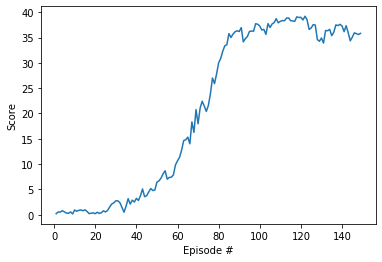

In [9]:
def ddpg(n_episodes, max_t, print_every, eps_start, eps_end, eps_decay):
    scores_deque = deque(maxlen=100)
    scores = []
    epss = []
    scheduler_criticstep = []
    scheduler_actorstep = []
    max_score = -np.Inf
    eps = eps_start                    # initialize epsilon
    step = 0
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations            # get the current state
        agent.reset()
        score = 0
        scoreWile = np.zeros(num_agents)
        while True:
            step += 1
            actions = agent.act(states, eps, add_noise=True)
            #next_state, reward, done, _ = env.step(action)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones, step)
            states = next_states
            scoreWile += rewards
            if np.any(dones):
                break 
                
        score = np.mean(scoreWile)
        scores_deque.append(score)
        scores.append(score)
        
#         criticLR = agent.scheduler_criticstep(score)
#         actorLR = agent.scheduler_actorstep(score)
#         scheduler_criticstep.append(criticLR)
#         scheduler_actorstep.append(actorLR)
    
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        epss.append(eps)
        timedots = (time.time() - starttime)
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
#         print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\teps: {:.2f}\tcriticLR: {:.6f}\tactorLR: {:.6f}'
#               .format(i_episode, np.mean(scores_deque), score, eps, criticLR, actorLR), end="")
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'
              .format(i_episode, np.mean(scores_deque), score), end="")
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor8.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic8.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}\ttime: {:.2f}'
                  .format(i_episode, np.mean(scores_deque), timedots))   
            
            # save model if validation loss has decreased
        if score-1 >= np.max(scores_deque):
            print('\rNew High Score!({:.2f} --> {:.2f}).  Saving model ...'.format(
                score, np.max(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor8hs.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic8hs.pth')
        
        if np.mean(scores_deque) >= 30:
            print('\r30+ solved!({:.2f} --> {:.2f}).  Saving model ...'.format(
                score, np.max(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor8s.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic8s.pth')
            break
        
    return scores ,scheduler_criticstep, scheduler_actorstep, epss

print(f"Time Stage: {(time.time() - starttime):.3f} seconds")
scores, criticstep, actorstep, epss = ddpg(n_episodes, max_t, print_every, eps_start, eps_end, eps_decay)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


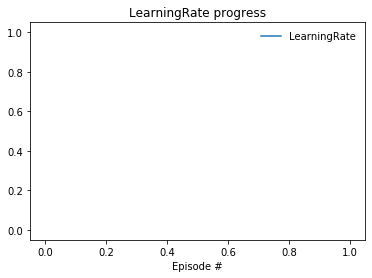

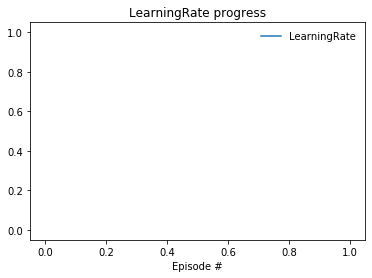

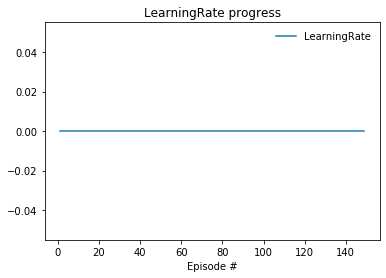

In [10]:
plotda_learning(criticstep)
plotda_learning(actorstep)
plotda_learning(epss)

In [11]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor8.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic8.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
step = 0
while True:
    step += step
    actions = agent.act(states) # select an action (for each agent)
    #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    agent.step(states, actions, rewards, next_states, dones, step)
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 33.04749926133081


In [13]:
env.close()

# differences

cut out eps, halved noise injection rate when true, no dropout, 
no scheduler, no amsgrad=True, cut layers from 4 to 3, 


machine differences
No hyper-threading (SMT), No AMD-V support, No IOMMU 